In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import torchvision.utils as utils
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
import os
import numpy as np
import matplotlib.pyplot as plt
from imbalancer import Imbalancer

## Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, input_dim, img_channels, features_g):
        super().__init__()
        self.net = nn.Sequential(
            self._block(input_dim, features_g * 8, 4, 1, 0),   # 4x4
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # 8x8
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # 16x16
            nn.ConvTranspose2d(features_g * 2, img_channels, 4, 2, 1),  # 32x32
            nn.Tanh()
        )
        # Crop from 32x32 to 28x28 in forward

    def _block(self, in_channels, out_channels, kernel, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)

## Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self, img_channels, features_d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, features_d, 4, 2, 1),   # 28 -> 14
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),  # 14 -> 7
            self._block(features_d * 2, features_d * 4, 3, 2, 1),  # 7 -> 4 (adjusted)
            nn.Conv2d(features_d * 4, 1, 4, 1, 0),           # output 1x1
        )

    def _block(self, in_channels, out_channels, kernel, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.net(x).view(-1)

## Hyperparameters

In [6]:
batch_size = 128
noise_dim = 100
image_size = 32
img_channels = 1
features_gen = 64
features_disc = 64
epochs = 500
alpha = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

## Load & Imbalance The Dataset (2 approaches)

In [ ]:
dataset = torchvision.datasets.FashionMNIST(root="./", train=True, download=True, transform=transform)
images = np.stack([np.array(img) for img, _ in dataset])
labels = [label for _, label in dataset]
minor_class = 1
imb = Imbalancer(images, labels, minor_class=minor_class, keep_ratio=0.2, output_path="../imbalanced_dataset_DCGAN_fashion_mnist")
imb.imbalance()
imb.visualize()
imb.save()

data = torch.load("../imbalanced_dataset_DCGAN_fashion_mnist/data.pt") # Produced by imbalancer.py
labels = torch.load("../imbalanced_dataset_DCGAN_fashion_mnist/labels.pt") # Produced by imbalancer.py
mask = labels == 1
filtered_data = data[mask]
filtered_labels = labels[mask]

#====================================================================================
# Loading locally

# dataset = torchvision.datasets.FashionMNIST(root="./", train=True, download=True, transform=transform)
# images = np.stack([np.array(img) for img, _ in dataset])
# labels = [label for _, label in dataset]
# targets = np.array(dataset.targets)
# class_counts = {i: 5000 for i in range(10)}
# class_counts[1] = 500  # Make class 1 smaller

# indices = []
# for cls, count in class_counts.items():
#     cls_indices = np.where(targets == cls)[0]
#     indices.extend(cls_indices[:count])
# imbalanced_subset = Subset(dataset, indices)

# images = []
# labels = []
# for img, label in imbalanced_subset:
#     images.append(img)
#     labels.append(label)
# images = torch.stack(images)
# labels = torch.tensor(labels)

# images = []
# labels = []

# for img, label in imbalanced_subset:
#     images.append(img)
#     labels.append(label)

# images = torch.stack(images)
# labels = torch.tensor(labels)
# mask_0 = labels == 1


# images_1 = images[mask_0]
# labels_1 = labels[mask_0]
# dataset_1 = TensorDataset(images_1, labels_1)
# len(dataset_1)

In [ ]:
dataset = TensorDataset(filtered_data, filtered_labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Create Generator & Discriminator

In [11]:
gen = Generator(noise_dim, img_channels, features_gen).to(device)
gen_optim = optim.Adam(gen.parameters(), lr=alpha, betas=(0.5, 0.9))
disc = Discriminator(img_channels, features_disc).to(device)
disc_optim = optim.Adam(disc.parameters(), lr=alpha, betas=(0.5, 0.9))
criterion = nn.BCEWithLogitsLoss()

In [ ]:
def show_generated_imgs(fake_imgs, real_imgs, epoch, nrow=8):
    # De-normalize from [-1, 1] to [0, 1]
    fake_imgs = fake_imgs[:nrow * nrow] * 0.5 + 0.5
    real_imgs = real_imgs[:nrow * nrow] * 0.5 + 0.5

    fake_grid = torchvision.utils.make_grid(fake_imgs, nrow=nrow).permute(1, 2, 0).cpu().numpy()
    real_grid = torchvision.utils.make_grid(real_imgs, nrow=nrow).permute(1, 2, 0).cpu().numpy()

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    axs[0].imshow(real_grid)
    axs[0].set_title("Real Images")
    axs[0].axis("off")

    axs[1].imshow(fake_grid)
    axs[1].set_title(f"Generated Images (Epoch {epoch})")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()


## Training

In [ ]:
for epoch in range(epochs):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        batch_size_curr = real.size(0)

        # === Generate fake images ===
        noise = torch.randn(batch_size_curr, noise_dim, 1, 1).to(device)
        fake = gen(noise)

        # === Add noise to real and fake images ===
        noise_std = 0.05
        real_noisy = real + noise_std * torch.randn_like(real)
        fake_noisy = fake + noise_std * torch.randn_like(fake)
        real_noisy = torch.clamp(real_noisy, -1, 1)
        fake_noisy = torch.clamp(fake_noisy, -1, 1)

        # === Train Discriminator ===
        disc_real = disc(real_noisy).view(-1)
        real_labels = torch.full_like(disc_real, 0.9)  # label smoothing
        lossD_real = criterion(disc_real, real_labels)

        disc_fake = disc(fake_noisy.detach()).view(-1)
        fake_labels = torch.zeros_like(disc_fake)
        lossD_fake = criterion(disc_fake, fake_labels)

        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward()
        disc_optim.step()

        # === Train Generator ===
        output = disc(fake_noisy).view(-1)
        gen_labels = torch.ones_like(output)  # D(fake) -> 1
        lossG = criterion(output, gen_labels)

        gen.zero_grad()
        lossG.backward()
        gen_optim.step()

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs} | D Loss: {lossD.item():.4f} | G Loss: {lossG.item():.4f}")

    if epoch % 10 == 0 or epoch == epochs - 1:
        show_generated_imgs(fake, real, epoch)

## Show Samples of The Generated Images

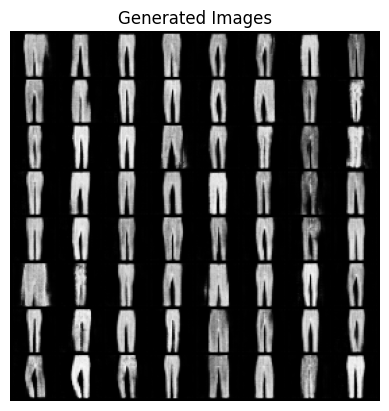

In [14]:
with torch.no_grad():
    noise = torch.randn(64, noise_dim, 1, 1).to(device)
    fake_images = gen(noise) * 0.5 + 0.5

    grid = torchvision.utils.make_grid(fake_images, nrow=8)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title("Generated Images")
    plt.axis("off")
    plt.show()

## Save The Model

In [ ]:
save_dir = "../saved_models"
os.makedirs(save_dir, exist_ok=True)
torch.save(gen.state_dict(), os.path.join(save_dir, f"DCGAN_generator_fashion_mnist_epoch_{epochs}.pth"))
torch.save(disc.state_dict(), os.path.join(save_dir, f"DCGAN_discriminator_fashion_mnist_epoch_{epochs}.pth"))

## Balancing The Dataset for Representation

In [ ]:
gen_path = f"../saved_models/DCGAN_generator_fashion_mnist_epoch_{epochs}.pth"
imbalanced_data_path = "../imbalanced_dataset_DCGAN_fashion_mnist/data.pt"
imbalanced_labels_path = "../imbalanced_dataset_DCGAN_fashion_mnist/labels.pt"
output_balanced_dir = "../balanced_dataset_DCGAN_fashion_mnist"

minor_class = 1

os.makedirs(output_balanced_dir, exist_ok=True)

data = torch.load(imbalanced_data_path)
labels = torch.load(imbalanced_labels_path)


if data.dim() == 3:
    data = data.unsqueeze(1)



class_counts = torch.bincount(labels)
max_count = class_counts.max().item()
minor_count = class_counts[minor_class].item()
num_to_generate = max_count - minor_count
print(f"Need to generate {num_to_generate} samples for class {minor_class}.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gen = Generator(noise_dim, img_channels, features_gen).to(device)
gen.load_state_dict(torch.load(gen_path, map_location=device))
gen.eval()


generated_images = []

with torch.no_grad():
    for _ in range((num_to_generate + batch_size - 1) // batch_size):
        current_batch_size = min(batch_size, num_to_generate - len(generated_images))
        noise = torch.randn(current_batch_size, noise_dim, 1, 1).to(device)
        fake_imgs = gen(noise).cpu()
        # fake_imgs = torch.nn.functional.interpolate(fake_imgs, size=(28, 28), mode='bilinear', align_corners=False)
        # fake_imgs = ((fake_imgs + 1) / 2).clamp(0, 1)
        generated_images.append(fake_imgs)

generated_images = torch.cat(generated_images, dim=0)
generated_labels = torch.full((generated_images.size(0),), minor_class, dtype=torch.long)


balanced_data = torch.cat([data, generated_images], dim=0)
balanced_labels = torch.cat([labels, generated_labels], dim=0)

torch.save(balanced_data, os.path.join(output_balanced_dir, "data.pt"))
torch.save(balanced_labels, os.path.join(output_balanced_dir, "labels.pt"))



print(f"Balanced dataset saved to: {output_balanced_dir}")

## Classes Distribution Before & After

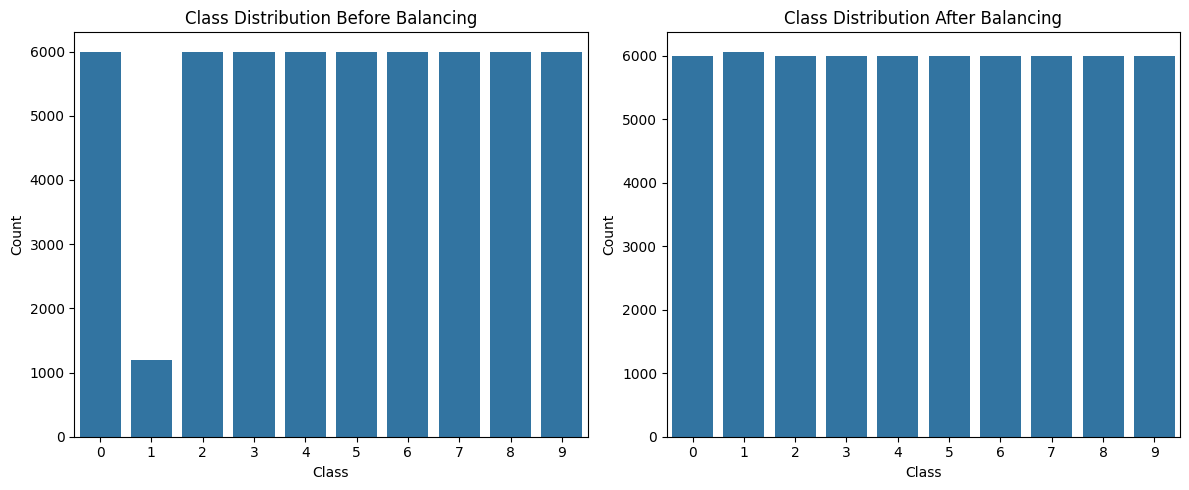

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Before balancing
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=labels.numpy())
plt.title('Class Distribution Before Balancing')
plt.xlabel('Class')
plt.ylabel('Count')

# After balancing
plt.subplot(1, 2, 2)
sns.countplot(x=balanced_labels.numpy())
plt.title('Class Distribution After Balancing')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()